In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
filenames = {'dev': 'data/korean_ner_data/dev.txt',
            'test': 'data/korean_ner_data/test.txt',
            'train': 'data/korean_ner_data/train.txt'}

tag_UNK = 0
tag_PAD = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {tag_UNK: "<UNK>", tag_PAD: "<PAD>"}
        self.n_words = 2  # UNK 와 PAD 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

engdict = Lang('KOR')
posdict = Lang('BIO')
MAX_LENGTH = 0
for filename in filenames.values():
    with open(filename, 'r', encoding='UTF8') as fp:
        words = []
        BIOs = []
        lines = fp.readlines()
        for line in lines:
            if line == '\n':
                LENGTH = len(words)
                if MAX_LENGTH < LENGTH:
                    MAX_LENGTH = LENGTH
                words = []
                BIOs = []
                continue
            pair = line.strip().split('\t')
            word = pair[0].split('/')[0]
            words.append(word)
            BIOs.append(pair[3])
            engdict.addSentence(word)
            posdict.addSentence(pair[3])

num_words = engdict.n_words
num_poss = posdict.n_words
print(num_words)
print(num_poss)
print(MAX_LENGTH)

14096
23
245


In [4]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]
def sentenceFromIndexes(lang, indexes):
    return [lang.index2word[idx] for idx in indexes]
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    PAD_indexes = [tag_PAD for i in range(MAX_LENGTH - len(indexes))]
    indexes.extend(PAD_indexes)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(MAX_LENGTH)
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(engdict, pair[0])
    target_tensor = tensorFromSentence(posdict, pair[1])
    return (input_tensor, target_tensor)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, filename):
        #   데이터셋의 전처리를 해주는 부분
        data=[[],[]]
        with open(filename, 'r', encoding='UTF8') as fp:
            words = []
            BIOs = []
            lines = fp.readlines()
            for line in lines:
                if line == '\n':
                    pair = tensorsFromPair((' '.join(words), ' '.join(BIOs)))
                    data[0].append(pair[0])
                    data[1].append(pair[1])
                    words = []
                    BIOs = []
                    continue
                pair = line.strip().split('\t')
                words.append(pair[0].split('/')[0])
                BIOs.append(pair[3])
        self.x_data = data[0]
        self.y_data = data[1]
        
    def __len__(self):
        #   데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
        return len(self.x_data)

    def __getitem__(self, idx): 
        #   데이터셋에서 특정 1개의 샘플을 가져오는 함수
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [6]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, size_hidden, num_poss, num_layers):
        super(BiLSTM, self).__init__()

        self.word_embedding = nn.Embedding(num_words, embedding_dim, padding_idx=tag_PAD,)
        self.lstm = nn.LSTM(embedding_dim, size_hidden, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.linear = nn.Linear(size_hidden*2, num_poss)
        self.dropout = nn.Dropout(0.25)
 
    def forward(self, input_seq):
        # print(input_seq.size())
        # batch-seq(1 feature)

        output_seq = self.word_embedding(input_seq)
        # print(output_seq.size())
        # batch-seq-embedding_dim

        output_seq, (h_n, c_n) = self.lstm(output_seq)
        # print(output_seq.size())
        # batch-seq-size_hidden*2(BiDirection)
        # print(h_n.size())
        # 2(BiDirection)-batch-size_hidden

        output = self.linear(self.dropout(output_seq))
        # print(output.size())
        # batch-seq-num_poss

        return output #, output_seq, (h_n, c_n)

In [7]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [9]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [10]:
def score1_acc_sample(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total = len(dataset)
    cnt_corr = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(x_train.size(0)):
            d = tagged[i]!=y_train[i]
            if tagged[i][d].size()[0] == 0:
                cnt_corr +=1

    # print(f'{cnt_corr / total * 100:.4}%')
    return cnt_corr / total

In [11]:
def score2_acc_word(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_words = 0
    cnt_corr = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(x_train.size(0)):
            l = tagged[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            total_words += seq_len
            d = tagged[i,:seq_len]==y_train[i,:seq_len]
            cnt_corr += tagged[i,:seq_len][d].size()[0]

    # print(f'{cnt_corr} / {total_words}\t{cnt_corr / total_words * 100:.4}%')
    return cnt_corr / total_words

In [12]:
def score3_f1(model, dataset, batch_size):
    c = posdict.n_words
    table = torch.zeros(c,c)
    # print(table.size())
    # return
    
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # total_words = 0
    # cnt_corr = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(x_train.size(0)):
            l = tagged[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            for j in range(seq_len):
                table[y_train[i,j],tagged[i,j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum

    # print(ttttf1)
    return avg_f1.item()

In [13]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(x_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / total_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [14]:
def train_score(model, optimizer, criterion, datasets, batch_size, num_epoch, score_func):
    dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)

    score_train = []
    score_dev = []
    for epoch_i in range(num_epoch):
        temp = epoch(model, optimizer, criterion, dataloader)
        score_train.append(score_func(model, datasets['train'], 100))
        score_dev.append(score_func(model, datasets['dev'], 100))

    return score_train, score_dev

In [15]:
def train_loss(model, optimizer, criterion, datasets, batch_size, num_epoch):
    dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
    dataloader_dev = DataLoader(datasets['dev'], batch_size=len(datasets['dev']), shuffle=True)
    
    list_loss_iteration = []
    dict_loss_dev = {}
    for epoch_i in range(num_epoch):
        temp = epoch(model, optimizer, criterion, dataloader)
        list_loss_iteration.extend(temp)
        dict_loss_dev[len(list_loss_iteration)] = evaluate(model, criterion, dataloader_dev)
        
    return list_loss_iteration, dict_loss_dev

In [16]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):
    dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
    dataloader_dev = DataLoader(datasets['dev'], batch_size=len(datasets['dev']), shuffle=True)
    dataloader_test = DataLoader(datasets['test'], batch_size=len(datasets['test']), shuffle=True)

    dict_losses={'train': [],
                 'dev': [],
                 'test': []}
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]}
    
    for epoch_i in range(num_epoch):
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])

    print()
    return dict_losses, dict_scores

In [17]:
def showParallel(words, tags, targets=None):
    if '<PAD>' in words:
        length = words.index('<PAD>')
    else:
        lengths = [len(words),len(tags)]        
        if targets is not None:
            lengths.append(len(targets))
        length = min(lengths)
    
    if targets is not None:
        print(f'{"words":20}{"tags":8}targets')
        for i in range(length):
            color = 31 if tags[i] != targets[i] else 0
            print(f'\033[{color}m{words[i]:20}{tags[i]:8}{targets[i]}\033[0m')
    else:
        print(f'{"words":20}tags')
        for i in range(length):
            print(f'{words[i]:20}{tags[i]}')

In [18]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [19]:
datasets = {'dev': CustomDataset(filenames['dev']),
           'test': CustomDataset(filenames['test']),
           'train': CustomDataset(filenames['train'])}
# dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

250
500
4250


In [20]:
embedding_dim = 100
size_hidden = 100
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [21]:
model = BiLSTM(embedding_dim, size_hidden, size_out, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 10
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)



9


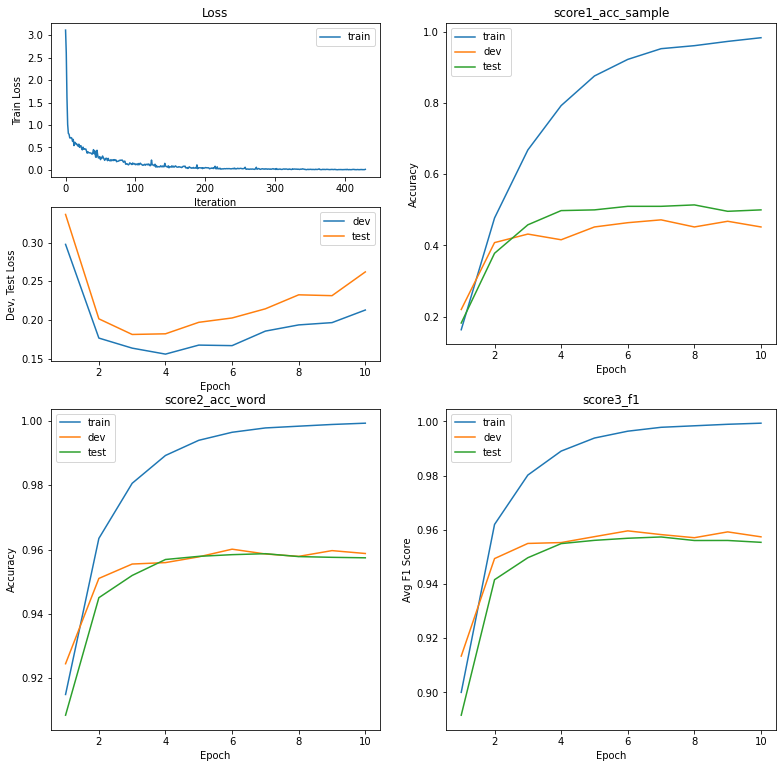

In [22]:
plt.figure(figsize=(13,13))

plt.subplot(421)
plt.title('Loss')
plt.plot(range(len(dict_losses['train'])), dict_losses['train'], label='train')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(423)
plt.plot(range(1,num_epoch+1), dict_losses['dev'], label='dev')
plt.plot(range(1,num_epoch+1), dict_losses['test'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Dev, Test Loss')
plt.legend()

plt.subplot(222)
plt.plot(range(1,num_epoch+1), dict_scores['train'][0], label='train')
plt.plot(range(1,num_epoch+1), dict_scores['dev'][0], label='dev')
plt.plot(range(1,num_epoch+1), dict_scores['test'][0], label='test')
plt.legend()
plt.title('score1_acc_sample')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(223)
plt.plot(range(1,num_epoch+1), dict_scores['train'][1], label='train')
plt.plot(range(1,num_epoch+1), dict_scores['dev'][1], label='dev')
plt.plot(range(1,num_epoch+1), dict_scores['test'][1], label='test')
plt.legend()
plt.title('score2_acc_word')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(224)
plt.plot(range(1,num_epoch+1), dict_scores['train'][2], label='train')
plt.plot(range(1,num_epoch+1), dict_scores['dev'][2], label='dev')
plt.plot(range(1,num_epoch+1), dict_scores['test'][2], label='test')
plt.legend()
plt.title('score3_f1')
plt.xlabel('Epoch')
plt.ylabel('Avg F1 Score')

plt.show()

In [23]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 342
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
#     print(target_seq)

    input_list = sentenceFromIndexes(engdict, input_seq.tolist())
#     print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = sentenceFromIndexes(posdict, pos_tagging(model, input_seq.unsqueeze(0)).view(-1).tolist())
    target_list = sentenceFromIndexes(posdict, target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)
    break

words               tags    targets
2002                B-DT    B-DT
년                   I-DT    I-DT
말                   I-DT    I-DT
일본                  B-LC    B-LC
교토                  O       B-OG
퍼플상가                O       I-OG
를                   O       O
떠난                  O       O
지                   O       O
5                   B-DT    B-DT
년                   I-DT    I-DT
이                   O       O
넘                   O       O
는                   O       O
시간                  O       O
이                   O       O
흘렀                  O       O
지만                  O       O
박지성                 B-PS    B-PS
의                   O       O
일본어                 O       O
실력                  O       O
은                   O       O
여전                  O       O
했                   O       O
다                   O       O
.                   O       O


In [24]:
score_type=2
for i in range(10):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')


0.90003   0.9134   0.8916
0.962   0.9494   0.94161
0.98022   0.955   0.94972
0.98907   0.9553   0.95493
0.99389   0.9575   0.95613
0.99642   0.9596   0.95691
0.99785   0.9583   0.95738
0.99841   0.9571   0.95607
0.99897   0.9593   0.95609
0.99937   0.9574   0.9554
